libs and defs

In [169]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf

# Load the S-parameter file
bjt = rf.Network('valores.s2p', )

# Filter for 4 GHz
freq_idx = np.where(np.isclose(bjt.f, 4e9, atol=1e6))[0][0]
freq_point = bjt[freq_idx]

z0 = 50

# Define a function to calculate the square of the absolute value
def sqabs(x): return np.square(np.absolute(x))



Stability

C:\Users\sofia\AppData\Local\Temp\ipykernel_25044\149904524.py:13: RuntimeWarning: invalid value encountered in sqrt
  MAG = np.abs(bjt.s12.s/bjt.s21.s) * (k-np.sqrt(np.square(k)-1))


MAG at 4 GHz: 17.617140849920908


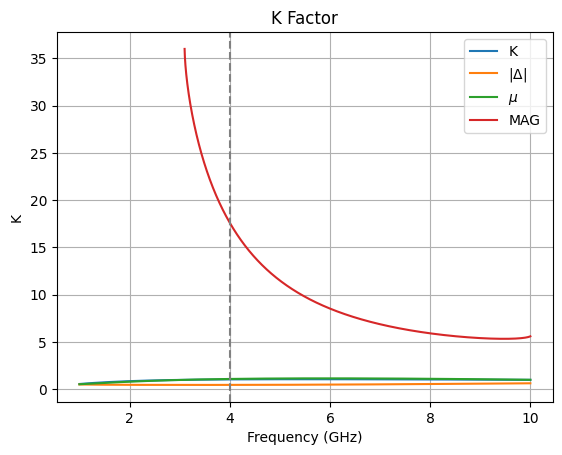

In [170]:
# delta is the determinant of the S-parameter matrix
delta = bjt.s11.s * bjt.s22.s - bjt.s12.s * bjt.s21.s

# k calculation
k = (1 - sqabs(bjt.s11.s) - sqabs(bjt.s22.s) + sqabs(delta)) / \
    (2 * np.abs(bjt.s12.s * bjt.s21.s))

# mu calculation
mu = (1 - sqabs(bjt.s11.s)) / (np.abs(bjt.s22.s -
                                      (delta*np.conj(bjt.s11.s)))+np.abs(bjt.s21.s*bjt.s12.s))

# Maximum available gain (MAG) calculation
MAG = np.abs(bjt.s12.s/bjt.s21.s) * (k-np.sqrt(np.square(k)-1))

k = np.squeeze(k)  # Remove any singleton dimensions
delta = np.squeeze(delta)  # Remove any singleton dimensions
mu = np.squeeze(mu)  # Remove any singleton dimensions
MAG = np.squeeze(MAG)  # Remove any singleton dimensions

# Print MAG at 4 Ghz
val = MAG[np.where(np.isclose(bjt.f, 4e9, atol=1e6))]
print('MAG at 4 GHz:', sum(val)/len(val))

# Plotting k values
plt.figure()
plt.plot(bjt.f/1e9, k)
plt.plot(bjt.f/1e9, np.abs(delta))
plt.plot(bjt.f/1e9, mu)
plt.plot(bjt.f/1e9, MAG)
#add line in 4 Ghz
plt.axvline(x=4, color='gray', linestyle='--')
plt.title('K Factor')
plt.xlabel('Frequency (GHz)')
plt.ylabel('K')
plt.grid()
plt.legend(['K', '|$\\Delta$|', '$\\mu$', 'MAG'])
plt.show()


Calc $\rho_L$ and $\rho_S$ and $\Z_L$ and $\Z_S$

In [171]:
# Calcular B1, B2, C1 e C2
print("Frequency (GHz):", bjt.f[freq_idx] / 1e9)
delta4GHz = delta[freq_idx]
print('delta4GHz:', delta4GHz)

# S11 and S22 for 4 GHz
s11 = freq_point.s11.s[0, 0]  # Extrair o valor numérico de S11
s22 = freq_point.s22.s[0, 0]  # Extrair o valor numérico de S22
print('S11:', s11)
print('S22:', s22)
print('|s11|: ', np.abs(s11))
print('|s22|: ', np.abs(s22))

B1 = 1 + sqabs(s11) - sqabs(s22) - sqabs(delta4GHz)
print('B1:', B1)
B2 = 1 + sqabs(s22) - sqabs(s11) - sqabs(delta4GHz)
print('B2:', B2)
C1 = s11 - (delta4GHz * np.conj(s22))
print('C1:', C1)
C2 = s22 - (delta4GHz * np.conj(s11))
print('C2:', C2)

# Calcular ros (ρs) e rol (ρL)
ros = (B1 - np.sqrt(np.square(B1) - 4 * sqabs(C1))) / (2 * C1)
rol = (B2 - np.sqrt(np.square(B2) - 4 * sqabs(C2))) / (2 * C2)
print("ros (ρs):", ros)
print("rol (ρL):", rol)
zs = (1 + ros) / (1 - ros)
zl = (1 + rol) / (1 - rol)
print("zs:", zs)
print("zl:", zl)

Frequency (GHz): 3.99944749760903
delta4GHz: (0.00848908504214558-0.4639058056379473j)
S11: [-0.42858028+0.33932163j]
S22: [-0.04270528+0.02900656j]
|s11|:  [0.54664451]
|s22|:  [0.05162482]
B1: [1.08087444]
B2: [0.48856424]
C1: [-0.41476144+0.31975664j]
C2: [0.11834624-0.16693379j]
ros (ρs): [-0.61550299-0.47451655j]
rol (ρL): [0.31333181+0.4419715j]
zs: [0.13967827-0.33475407j]
zl: [1.05943201+1.32554598j]


Calc matching source and load circuit with Lumped elements in L

In [172]:

def calc_lumped_matching_circuits(f, z0, rl, xl):
    Rl = rl
    Xl = xl
    if rl > 1: 
        b1 = (Xl + (np.sqrt(Rl/z0)*np.sqrt(np.square(Rl)+np.square(Xl)-z0*Rl)))/(np.square(Rl)+np.square(Xl))
        b2 = (Xl - (np.sqrt(Rl/z0)*np.sqrt(np.square(Rl)+np.square(Xl)-z0*Rl)))/(np.square(Rl)+np.square(Xl))

        x1 = 1/b1 + (Xl*z0/Rl) - (z0/(b1*Rl))
        x2 = - x1

        if b1 > 0:
            bmais = b1
            bmenos = b2
        else:
            bmais = b2
            bmenos = b1
        if x1 > 0:
            xmais = x1
            xmenos = x2
        else:
            xmais = x2
            xmenos = x1
        print("------------------------------------")
        print("Z0 - Xserie + Bparalelo - Z")
        print("B+ = ", bmais)
        print("X+ = ", xmais)
        print("B- = ", bmenos)
        print("X- = ", xmenos)
        print("------------------------------------")
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = -bmenos/(2*np.pi*f*z0)
        L_paralelo = z0/(bmais*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)

        
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    else:
        bmais = np.sqrt((z0-Rl)/Rl)/z0
        bmenos = -np.sqrt((z0-Rl)/Rl)/z0
        if Xl > 0:
            xmais = np.sqrt(Rl*(z0-Rl)) - Xl
            xmenos = -(np.sqrt(Rl*(z0-Rl))) - Xl
        else:
            xmais = np.sqrt(Rl*(z0-Rl)) + Xl
            xmenos = -(np.sqrt(Rl*(z0-Rl))) + Xl

        print("------------------------------------")
        print("Z0 - Bparalelo + Xserie - Z")
        print("X+ = ", xmais)
        print("X- = ", xmenos)
        print("B+ = ", bmais)
        print("B- = ", bmenos)
        z0 = 50
        L_serie = xmais*z0/(2*np.pi*f)
        C_paralelo = bmais/(2*np.pi*f*z0)
        L_paralelo = -z0/(bmenos*2*np.pi*f)
        C_serie = -1/(z0*xmenos*2*np.pi*f)
        print("L_serie = ", L_serie)
        print("C_paralelo = ", C_paralelo)
        print("L_paralelo = ", L_paralelo)
        print("C_serie = ", C_serie)
        print("------------------------------------")
    return

# Source matching
f = 4e9
rs = np.real(zs)
xs = np.imag(zs)

rl = np.real(zl)
xl = np.imag(zl)
# print("Source impedance: ", rs, "+ j", xs)
# print("Load impedance: ", rl, "+ j", xl)

print("------------------------------------")
print("Calc source matching circuit")
calc_lumped_matching_circuits(f, 1, rs, xs)
print("------------------------------------")
print("Calc load matching circuit")
calc_lumped_matching_circuits(f, 1, rl, xl)

------------------------------------
Calc source matching circuit
------------------------------------
Z0 - Bparalelo + Xserie - Z
X+ =  [0.01189886]
X- =  [-0.681407]
B+ =  [2.48179565]
B- =  [-2.48179565]
L_serie =  [2.36720218e-11]
C_paralelo =  [1.97495023e-12]
L_paralelo =  [8.01611843e-10]
C_serie =  [1.16784054e-12]
------------------------------------
------------------------------------
Calc load matching circuit
------------------------------------
Z0 - Xserie + Bparalelo - Z
B+ =  [0.94258516]
X+ =  [1.31070055]
B- =  [-0.02189715]
X- =  [-1.31070055]
------------------------------------
L_serie =  [2.60755589e-09]
C_paralelo =  [1.74251949e-14]
L_paralelo =  [2.11061757e-09]
C_serie =  [6.07136936e-13]
------------------------------------


Calc impedance matching with lines and stubs

In [173]:
def calc_lines_stubs_circuit(z0,zl):
    #calc admitance
    y0 = 1/z0
    rl = np.real(zl)
    xl = np.imag(zl)
    #shunt stubs
    print("------------------------------------")
    print("Calc shunt stubs")
    print("------------------------------------")
    if rl == z0:
        t = -xl/(2*z0)
        if t >= 0:
            l = 1/(2*np.pi)*np.arctan(t)
        else:
            l = 1/(2*np.pi)*(np.pi * np.arctan(t))
    else:
        t1 = (xl + np.sqrt(rl*((np.square(z0-rl)+np.square(xl)))/z0))/(rl-z0)
        t2 = (xl - np.sqrt(rl*((np.square(z0-rl)+np.square(xl)))/z0))/(rl-z0)
        print("t1:", t1)
        print("t2:", t2)
        t = t1
        G1 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
        print("G1:", G1)
        B1 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t))/(z0*(np.square(rl)+np.square(xl+z0*t)))
        print("B1:", B1)
        t = t2
        G2 = (rl*(1+np.square(t)))/(np.square(rl)+np.square(xl + z0*t))
        print("G2:", G2)
        B1 = (np.square(rl)*t - (z0-xl*t)*(xl+z0*t))/(z0*(np.square(rl)+np.square(xl+z0*t)))
        print("B2:", B2)
        #open circuit
        print(">>>>>>> Open circuit")
        l1 = -1/(2*np.pi)*np.arctan(B1/y0)
        print("l1:", l1)
        l2 = -1/(2*np.pi)*np.arctan(B2/y0)
        print("l2:", l2)
        #short circuit
        print(">>>>>>> Short circuit")
        l1 = 1/(2*np.pi)*np.arctan(y0/B1)
        print("l1:", l1)
        l2 = 1/(2*np.pi)*np.arctan(y0/B2)
        print("l2:", l2)

    #series stubs
    print("------------------------------------")
    print("Calc series stubs")
    print("------------------------------------")
    yl = 1/zl
    gl = np.real(yl)
    bl = np.imag(yl)
    if gl == y0:
        t = -bl/(2*y0)
        if t >= 0:
            l = 1/(2*np.pi)*np.arctan(t)
        else:
            l = 1/(2*np.pi)*(np.pi * np.arctan(t))
    else:
        t1 = (bl + np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
        print("t1:", t1)
        t2 = (bl - np.sqrt(gl*((np.square(y0-gl)+np.square(bl)))/y0))/(gl-y0)
        print("t2:", t2)
        t = t1
        R1 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
        print("R1:", R1)
        X1 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
        print("X1:", X1)
        t= t2
        R2 = (gl*(1+np.square(t)))/(np.square(gl)+np.square(bl + y0*t))
        print("R2:", R2)
        X2 = (np.square(gl)*t - (y0-bl*t)*(bl+y0*t))/(y0*(np.square(gl)+np.square(bl+y0*t)))
        print("X2:", X2)
        #short circuit
        print(">>>>>>> Short circuit")
        l1 = -1/(2*np.pi)*np.arctan(X1/z0)
        print("l1:", l1)
        l2 = -1/(2*np.pi)*np.arctan(X2/z0)
        print("l2:", l2)
        #open circuit
        print(">>>>>>> Open circuit")
        l1 = 1/(2*np.pi)*np.arctan(z0/X1)
        print("l1:", l1)
        l2 = 1/(2*np.pi)*np.arctan(z0/X2)
        print("l2:", l2)

print("------------------------------------")
print("Calc source matching circuit")
calc_lines_stubs_circuit(z0,zs)
print("\n------------------------------------")
print("Calc loud matching circuit")
calc_lines_stubs_circuit(z0,zl)

------------------------------------
Calc source matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [-0.04614154]
t2: [0.05956922]
G1: [0.02]
B1: [0.37735094]
G2: [0.02]
B2: [0.48856424]
>>>>>>> Open circuit
l1: [0.2415725]
l2: [-0.24348843]
>>>>>>> Short circuit
l1: [-0.0084275]
l2: [0.00651157]
------------------------------------
Calc series stubs
------------------------------------
t1: [21.67244314]
t2: [-16.78719355]
R1: [50.]
X1: [943.37734032]
R2: [50.]
X2: [-943.37734032]
>>>>>>> Short circuit
l1: [-0.2415725]
l2: [0.2415725]
>>>>>>> Open circuit
l1: [0.0084275]
l2: [-0.0084275]

------------------------------------
Calc loud matching circuit
------------------------------------
Calc shunt stubs
------------------------------------
t1: [-0.17270137]
t2: [0.11853175]
G1: [0.02]
B1: [0.13453544]
G2: [0.02]
B2: [0.48856424]
>>>>>>> Open circuit
l1: [0.22651209]
l2: [-0.24348843]
>>>>>>> Short circuit
l1: [-0.02348791]
l